In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sklearn

# Đọc dữ liệu
df = pd.read_csv('insurance.csv')

# Hiển thị 5 dòng đầu tiên
print("5 dòng đầu tiên của dữ liệu:")
print(df.head())

# Thông tin cơ bản về bộ dữ liệu
print("\nThông tin cơ bản về bộ dữ liệu:")
print(df.info())

# Thống kê mô tả
print("\nThống kê mô tả cho các cột số:")
print(df.describe())

# Đếm giá trị trong các cột phân loại
print("\nSố lượng giá trị trong các cột phân loại:")
for col in ['sex', 'smoker', 'region']:
    print(f"\n{col}:")
    print(df[col].value_counts())


5 dòng đầu tiên của dữ liệu:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Thông tin cơ bản về bộ dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Thống kê mô tả cho các cột s

Số lượng giá trị missing trong mỗi cột:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


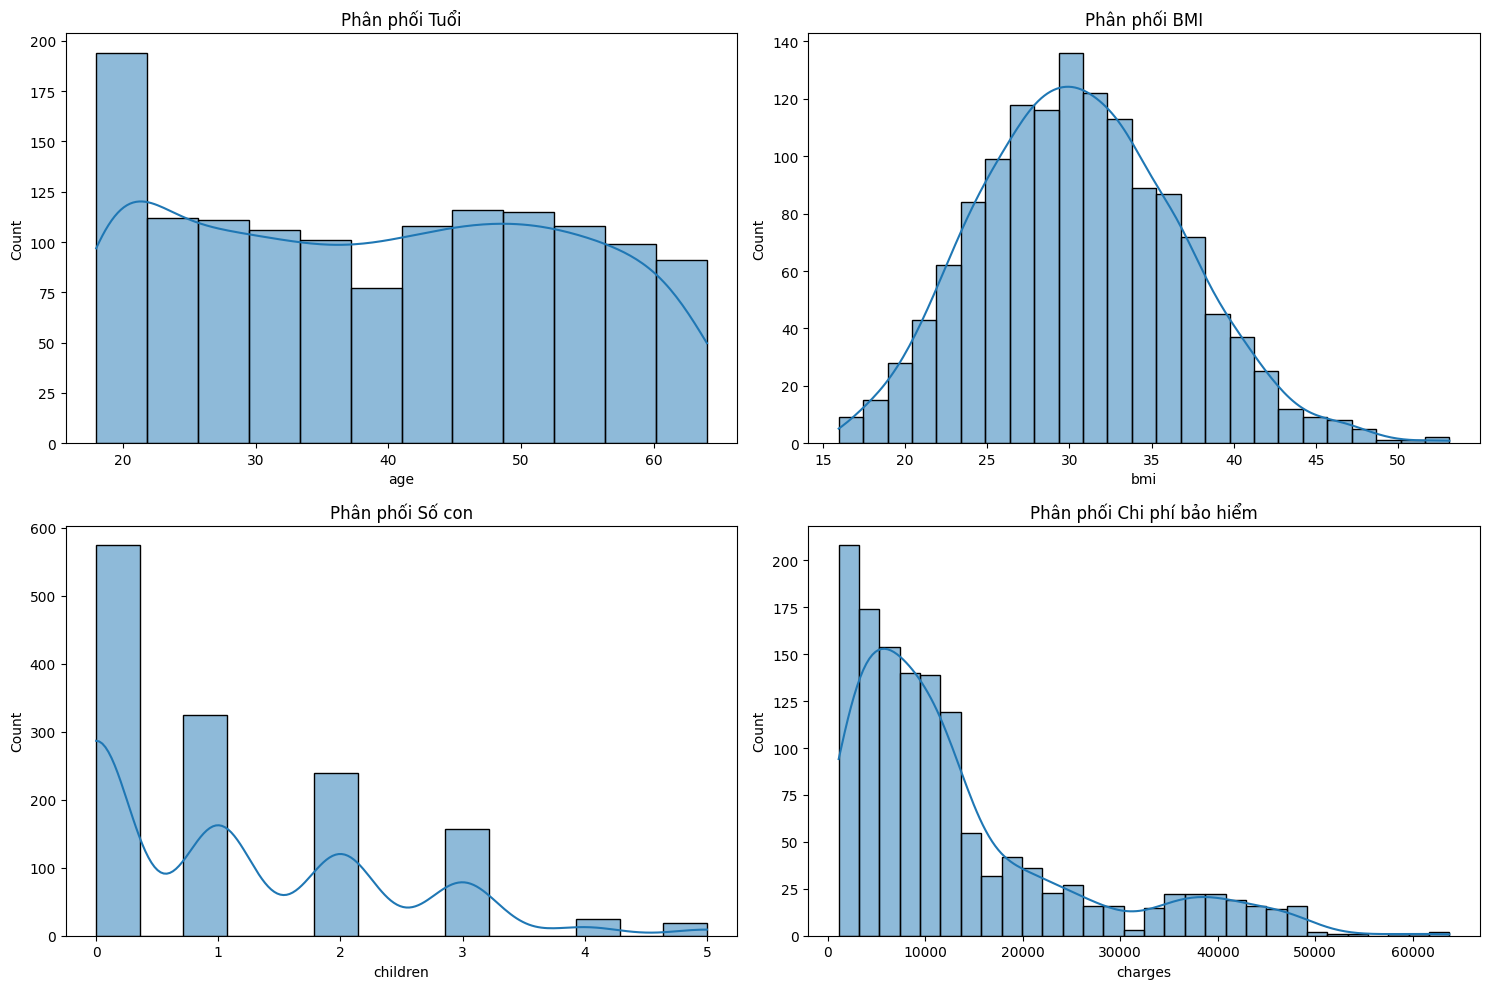

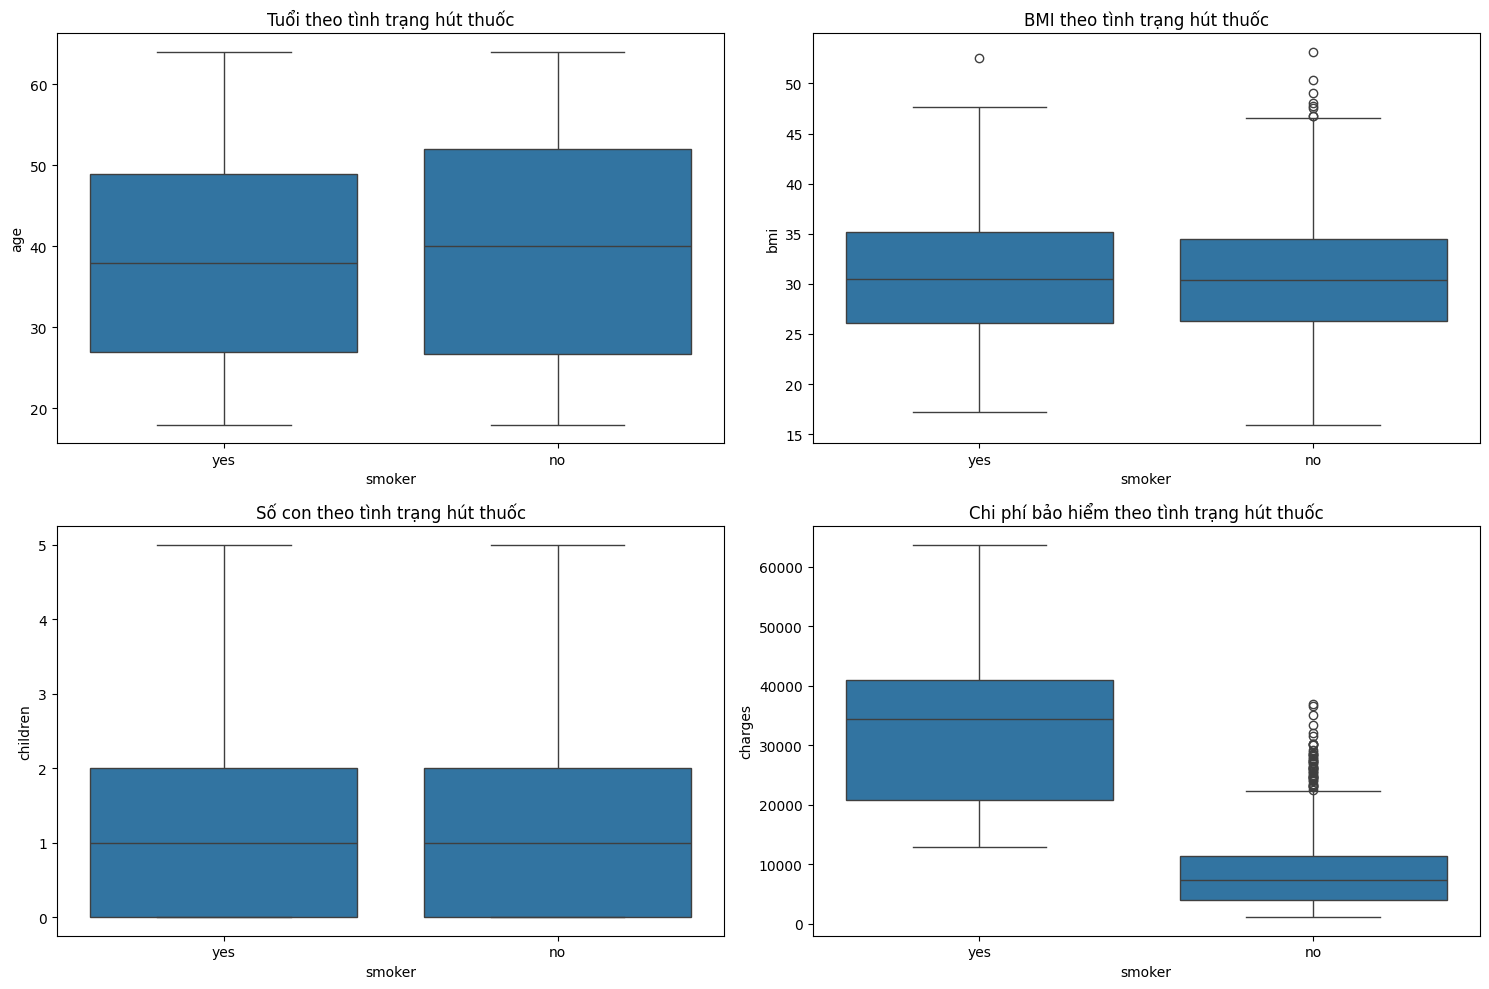

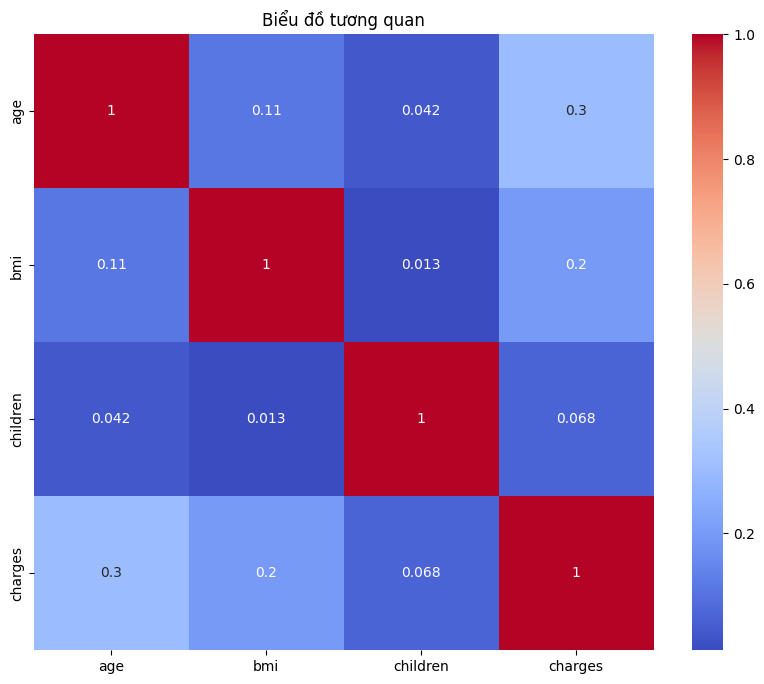

Số lượng outliers trong cột age: 0
Số lượng outliers trong cột bmi: 9
Số lượng outliers trong cột children: 0
Số lượng outliers trong cột charges: 139


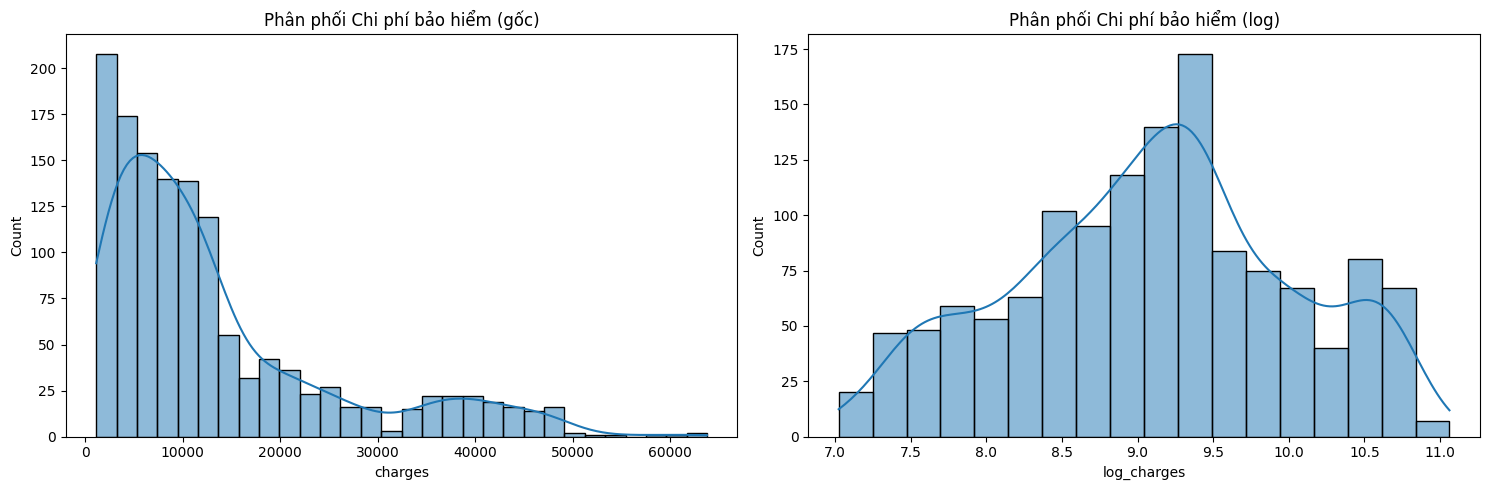

Kết luận và Insights:
1. Không có missing values trong bộ dữ liệu.
2. Phân phối tuổi khá đều, tập trung từ 18 đến 64 tuổi.
3. BMI có phân phối gần như chuẩn, với trung bình khoảng 30 (thừa cân).
4. Số con phần lớn từ 0-3, với một số ít trường hợp có 4-5 con.
5. Chi phí bảo hiểm có phân phối lệch phải, với một số trường hợp chi phí rất cao.
6. Người hút thuốc có chi phí bảo hiểm cao hơn đáng kể so với người không hút thuốc.
7. Có tương quan dương giữa tuổi và chi phí bảo hiểm, BMI và chi phí bảo hiểm.
8. Sau khi áp dụng log transformation, phân phối của chi phí bảo hiểm trở nên gần với phân phối chuẩn hơn, giúp xử lý vấn đề outliers.

Phân tích biến phân loại:

Phân bố của sex:
sex
male      0.505232
female    0.494768
Name: proportion, dtype: float64

Phân bố của smoker:
smoker
no     0.795217
yes    0.204783
Name: proportion, dtype: float64

Phân bố của region:
region
southeast    0.272048
southwest    0.242900
northwest    0.242900
northeast    0.242152
Name: proportion, dtype: float

In [31]:
# Kiểm tra missing values
print("Số lượng giá trị missing trong mỗi cột:")
print(df.isnull().sum())

# Trực quan hóa dữ liệu

# Phân phối của các biến số
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df['age'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Phân phối Tuổi')
sns.histplot(df['bmi'], kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Phân phối BMI')
sns.histplot(df['children'], kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Phân phối Số con')
sns.histplot(df['charges'], kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Phân phối Chi phí bảo hiểm')
plt.tight_layout()
plt.show()

# Biểu đồ hộp cho các biến số theo 'smoker'
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x='smoker', y='age', data=df, ax=axs[0, 0])
axs[0, 0].set_title('Tuổi theo tình trạng hút thuốc')
sns.boxplot(x='smoker', y='bmi', data=df, ax=axs[0, 1])
axs[0, 1].set_title('BMI theo tình trạng hút thuốc')
sns.boxplot(x='smoker', y='children', data=df, ax=axs[1, 0])
axs[1, 0].set_title('Số con theo tình trạng hút thuốc')
sns.boxplot(x='smoker', y='charges', data=df, ax=axs[1, 1])
axs[1, 1].set_title('Chi phí bảo hiểm theo tình trạng hút thuốc')
plt.tight_layout()
plt.show()

# Biểu đồ tương quan cho các cột số
numeric_columns = ['age', 'bmi', 'children', 'charges']
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Biểu đồ tương quan')
plt.show()

# Xử lý outliers
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Kiểm tra outliers trong các cột số
for column in numeric_columns:
    outliers = detect_outliers(df, column)
    print(f"Số lượng outliers trong cột {column}: {len(outliers)}")

# Xử lý outliers trong cột 'charges'
df['log_charges'] = np.log(df['charges'])

# Vẽ biểu đồ so sánh
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['charges'], kde=True, ax=ax1)
ax1.set_title('Phân phối Chi phí bảo hiểm (gốc)')
sns.histplot(df['log_charges'], kde=True, ax=ax2)
ax2.set_title('Phân phối Chi phí bảo hiểm (log)')
plt.tight_layout()
plt.show()

# In kết luận
print("Kết luận và Insights:")
print("1. Không có missing values trong bộ dữ liệu.")
print("2. Phân phối tuổi khá đều, tập trung từ 18 đến 64 tuổi.")
print("3. BMI có phân phối gần như chuẩn, với trung bình khoảng 30 (thừa cân).")
print("4. Số con phần lớn từ 0-3, với một số ít trường hợp có 4-5 con.")
print("5. Chi phí bảo hiểm có phân phối lệch phải, với một số trường hợp chi phí rất cao.")
print("6. Người hút thuốc có chi phí bảo hiểm cao hơn đáng kể so với người không hút thuốc.")
print("7. Có tương quan dương giữa tuổi và chi phí bảo hiểm, BMI và chi phí bảo hiểm.")
print("8. Sau khi áp dụng log transformation, phân phối của chi phí bảo hiểm trở nên gần với phân phối chuẩn hơn, giúp xử lý vấn đề outliers.")

# Phân tích thêm về các biến phân loại
print("\nPhân tích biến phân loại:")
for col in ['sex', 'smoker', 'region']:
    print(f"\nPhân bố của {col}:")
    print(df[col].value_counts(normalize=True))


Mean squared error: 33596915.85136145
R-squared score: 0.7835929767120724


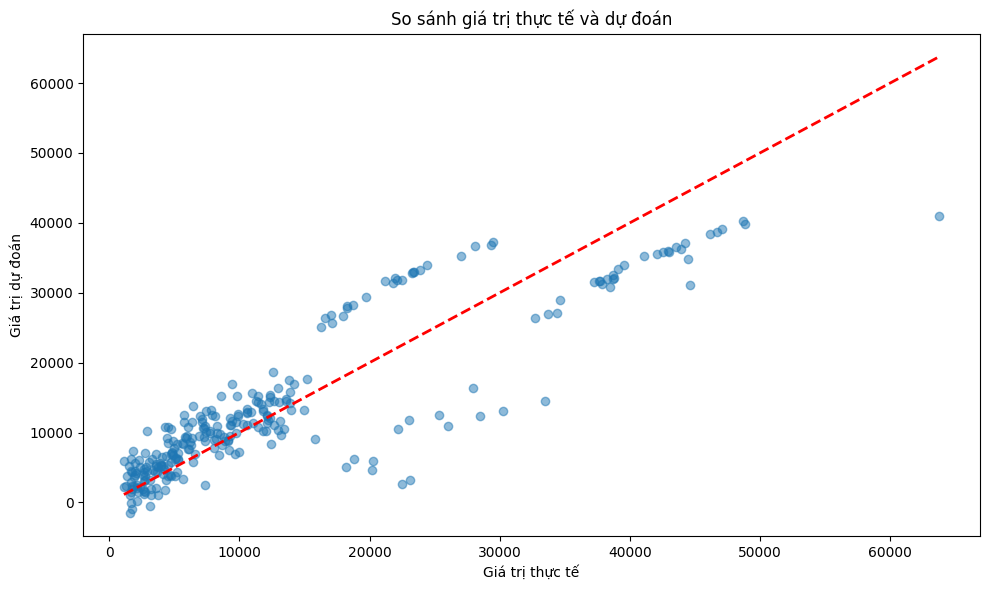


Hệ số hồi quy:
age: 256.9757058311941
bmi: 337.0925519487796
children: 425.2787835242982
sex_male: -18.591691641029808
smoker_yes: 23651.128855761235
region_northwest: -370.67732622778925
region_southeast: -657.8642965646411
region_southwest: -809.7993541824889
Intercept: -11931.219050326681

Tầm quan trọng của các features:
            feature  importance
0        smoker_yes  100.000000
1  region_southwest    3.423935
2  region_southeast    2.781534
3          children    1.798133
4  region_northwest    1.567271
5               bmi    1.425270
6               age    1.086526
7          sex_male    0.078608


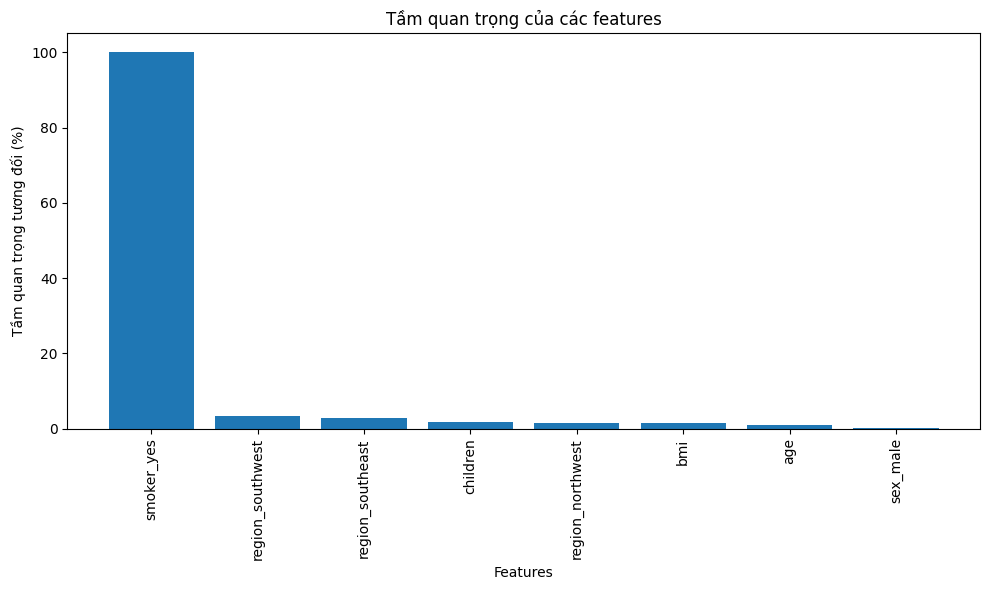

In [32]:
# Chia features (X) và target (y)
X = df.drop('charges', axis=1)
y = df['charges']

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tạo pipeline với preprocessing và model
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# Kiểm tra phiên bản scikit-learn để sử dụng đúng tham số
if sklearn.__version__ >= '0.24':
    onehot = OneHotEncoder(drop='first', sparse_output=False)
else:
    onehot = OneHotEncoder(drop='first', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', onehot, categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Huấn luyện mô hình
model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean squared error: {mse}')
print(f'R-squared score: {r2}')

# Visualize kết quả
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Giá trị thực tế')
plt.ylabel('Giá trị dự đoán')
plt.title('So sánh giá trị thực tế và dự đoán')
plt.tight_layout()
plt.show()

# In ra hệ số hồi quy
feature_names = numeric_features + [f"{feature}_{category}" for feature, categories in 
                                    zip(categorical_features, model.named_steps['preprocessor']
                                        .named_transformers_['cat'].categories_) 
                                    for category in categories[1:]]

coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

print("\nHệ số hồi quy:")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef}")
print(f"Intercept: {intercept}")

# Tính tầm quan trọng của các features
importance = np.abs(coefficients)
importance = 100.0 * (importance / importance.max())

feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

print("\nTầm quan trọng của các features:")
print(feature_importance)

# Visualize tầm quan trọng của features
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Tầm quan trọng tương đối (%)')
plt.title('Tầm quan trọng của các features')
plt.tight_layout()
plt.show()


Cross-validation RMSE scores: [6088.11519761 6174.2919068  5707.2614173  6299.30801411 6093.07039922]
Mean CV RMSE: 6072.41 (+/- 395.85)

Metrics trên tập test:
RMSE: 5796.28
R-squared: 0.78
MAE: 4181.19


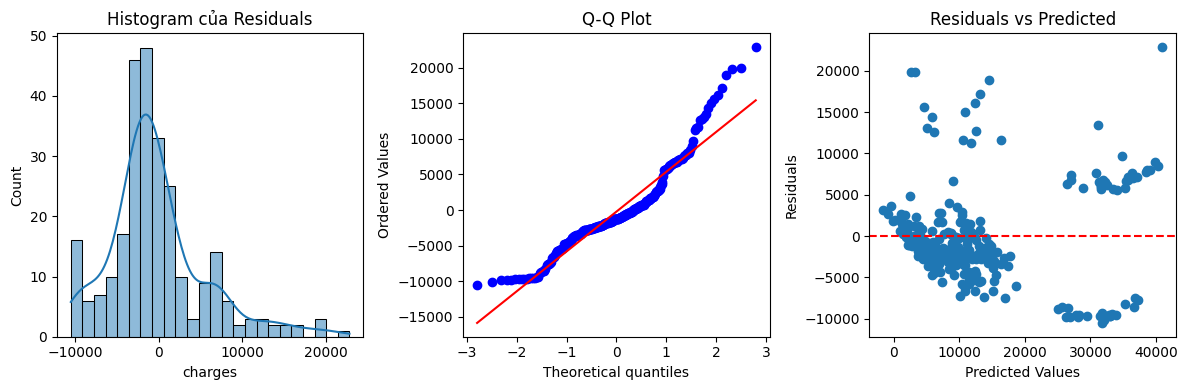

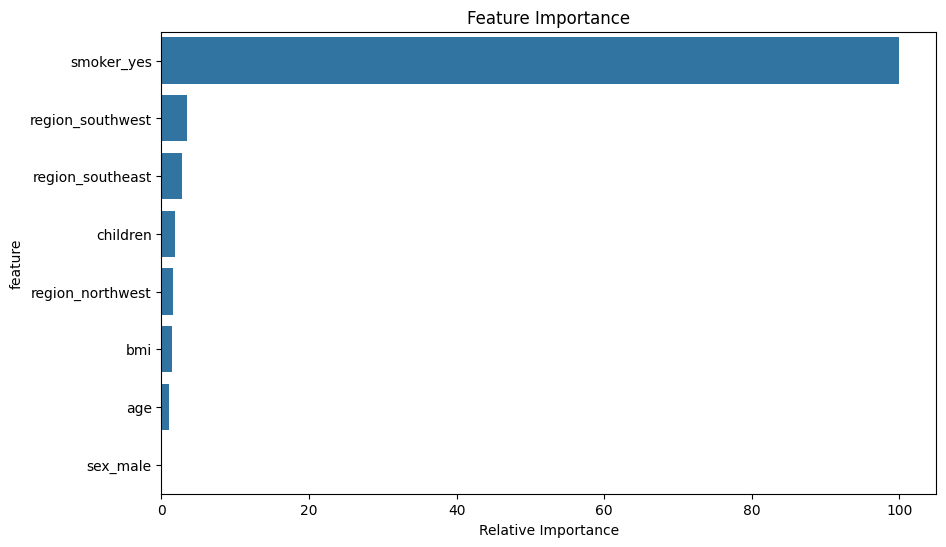

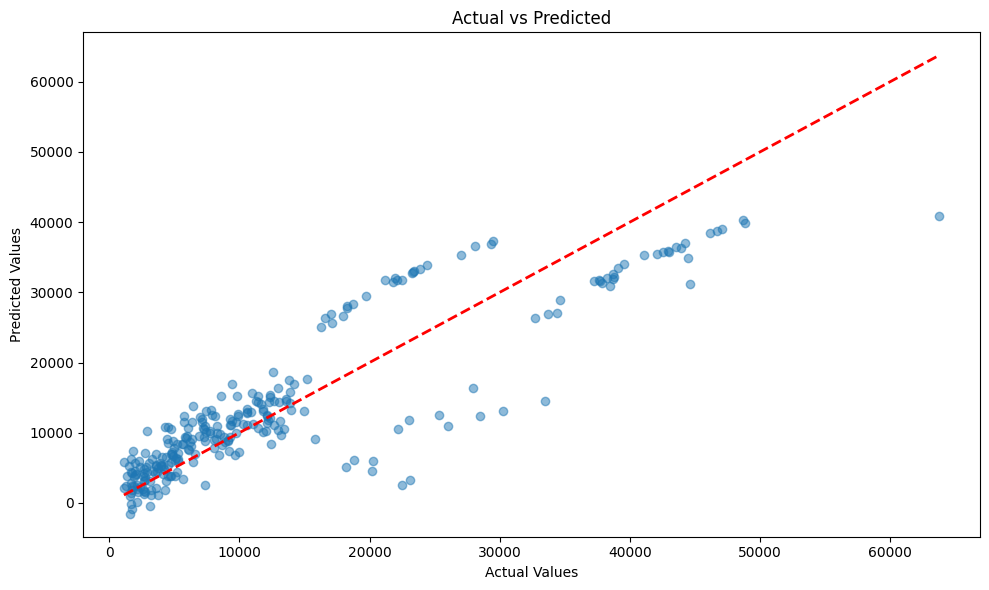


Feature Importance:
            feature  importance
0        smoker_yes  100.000000
1  region_southwest    3.423935
2  region_southeast    2.781534
3          children    1.798133
4  region_northwest    1.567271
5               bmi    1.425270
6               age    1.086526
7          sex_male    0.078608


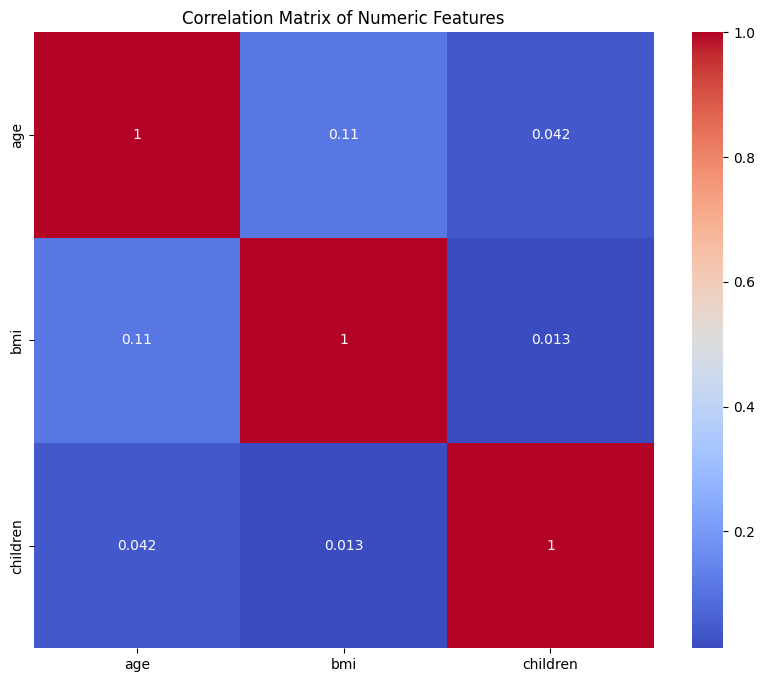

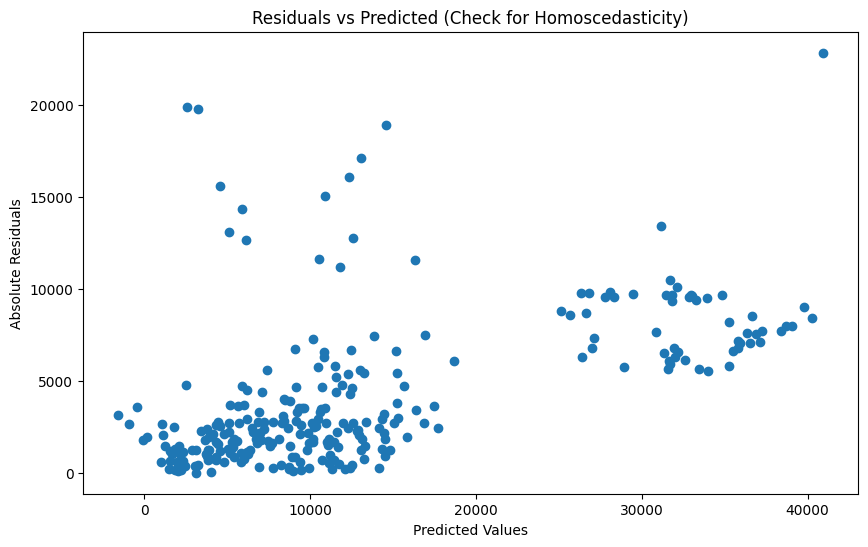

In [33]:
X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây dựng pipeline
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

if sklearn.__version__ >= '0.24':
    onehot = OneHotEncoder(drop='first', sparse_output=False)
else:
    onehot = OneHotEncoder(drop='first', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', onehot, categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Huấn luyện mô hình
model.fit(X_train, y_train)

# 1. Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse)
print("Mean CV RMSE: {:.2f} (+/- {:.2f})".format(cv_rmse.mean(), cv_rmse.std() * 2))

# 2. Đánh giá trên tập test
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nMetrics trên tập test:")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.2f}")
print(f"MAE: {mae:.2f}")

# 3. Residual Analysis
residuals = y_test - y_pred

plt.figure(figsize=(12, 4))

# Histogram của residuals
plt.subplot(131)
sns.histplot(residuals, kde=True)
plt.title('Histogram của Residuals')

# Q-Q plot
plt.subplot(132)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')

# Residuals vs Predicted
plt.subplot(133)
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# 4. Feature Importance
feature_names = numeric_features + [f"{feature}_{category}" for feature, categories in 
                                    zip(categorical_features, model.named_steps['preprocessor']
                                        .named_transformers_['cat'].categories_) 
                                    for category in categories[1:]]

coefficients = model.named_steps['regressor'].coef_
importance = np.abs(coefficients)
importance = 100.0 * (importance / importance.max())

feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Relative Importance')
plt.show()

# 5. Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.show()

print("\nFeature Importance:")
print(feature_importance)

# 6. Kiểm tra đa cộng tuyến
from sklearn.preprocessing import StandardScaler

X_numeric = X[numeric_features]
X_scaled = StandardScaler().fit_transform(X_numeric)
correlation_matrix = np.abs(np.corrcoef(X_scaled.T))

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=numeric_features, yticklabels=numeric_features)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# 7. Kiểm tra giả định về phương sai đồng nhất (homoscedasticity)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, np.abs(residuals))
plt.xlabel('Predicted Values')
plt.ylabel('Absolute Residuals')
plt.title('Residuals vs Predicted (Check for Homoscedasticity)')
plt.show()


In [34]:
X = df.drop('charges', axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây dựng pipeline
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

if sklearn.__version__ >= '0.24':
    onehot = OneHotEncoder(drop='first', sparse_output=False)
else:
    onehot = OneHotEncoder(drop='first', sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', onehot, categorical_features)
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Huấn luyện mô hình
model.fit(X_train, y_train)

# Đánh giá mô hình
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Kết quả trước khi lưu mô hình:")
print(f'Mean squared error: {mse}')
print(f'R-squared score: {r2}')

# Lưu mô hình
joblib.dump(model, 'insurance_model.joblib')
print("\nMô hình đã được lưu vào file 'insurance_model.joblib'")

# Tải lại mô hình
loaded_model = joblib.load('insurance_model.joblib')

# Kiểm tra mô hình đã tải
y_pred_loaded = loaded_model.predict(X_test)
mse_loaded = mean_squared_error(y_test, y_pred_loaded)
r2_loaded = r2_score(y_test, y_pred_loaded)

print("\nKết quả sau khi tải lại mô hình:")
print(f'Mean squared error: {mse_loaded}')
print(f'R-squared score: {r2_loaded}')

# So sánh kết quả dự đoán
print("\nSo sánh kết quả dự đoán:")
print("5 giá trị đầu tiên từ mô hình gốc:")
print(y_pred[:5])
print("\n5 giá trị đầu tiên từ mô hình đã tải:")
print(y_pred_loaded[:5])

# Kiểm tra xem kết quả có giống nhau không
is_same = np.allclose(y_pred, y_pred_loaded)
print(f"\nKết quả dự đoán từ hai mô hình có giống nhau không? {is_same}")

# Ví dụ sử dụng mô hình đã tải để dự đoán
new_data = pd.DataFrame({
    'age': [30],
    'sex': ['male'],
    'bmi': [25],
    'children': [1],
    'smoker': ['no'],
    'region': ['southwest']
})

prediction = loaded_model.predict(new_data)
print(f"\nDự đoán chi phí bảo hiểm cho dữ liệu mới: ${prediction[0]:.2f}")


Kết quả trước khi lưu mô hình:
Mean squared error: 33596915.85136145
R-squared score: 0.7835929767120724

Mô hình đã được lưu vào file 'insurance_model.joblib'

Kết quả sau khi tải lại mô hình:
Mean squared error: 33596915.85136145
R-squared score: 0.7835929767120724

So sánh kết quả dự đoán:
5 giá trị đầu tiên từ mô hình gốc:
[ 8969.55027444  7068.74744287 36858.41091155  9454.67850053
 26973.17345656]

5 giá trị đầu tiên từ mô hình đã tải:
[ 8969.55027444  7068.74744287 36858.41091155  9454.67850053
 26973.17345656]

Kết quả dự đoán từ hai mô hình có giống nhau không? True

Dự đoán chi phí bảo hiểm cho dữ liệu mới: $3802.25


Kết quả Random Forest:
MSE: 20942520.922619622
RMSE: 4576.299916157115
R-squared: 0.8651034329144947
MAE: 2550.0784706115096

Cross-validation RMSE (Random Forest):
Mean: 4863.799414037911, Std: 339.18400460086923


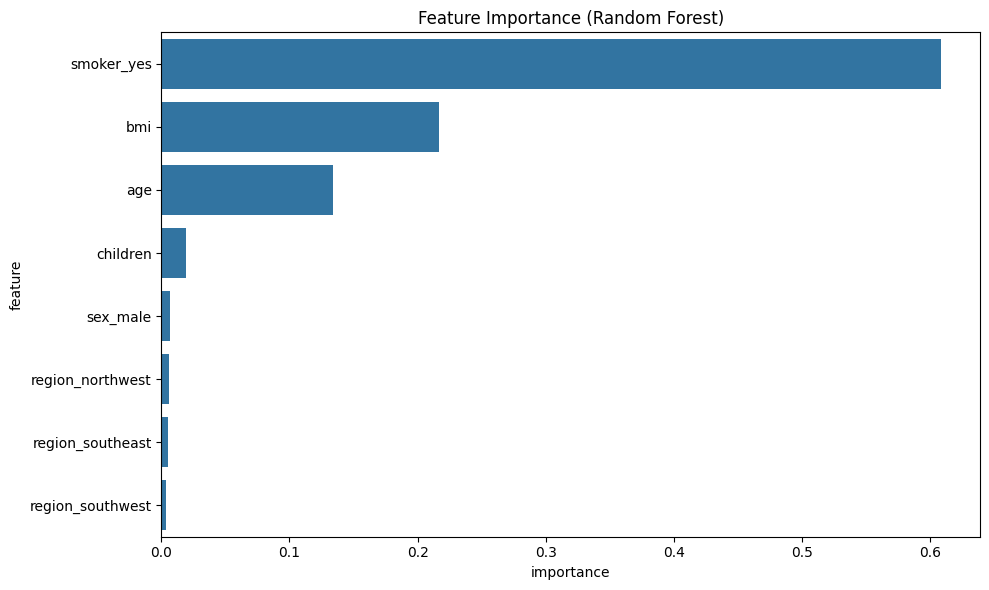


So sánh kết quả:
Metric         Random Forest       Linear Regression   
MSE            20942520.92         33596915.85         
RMSE           4576.30             5796.28             
R-squared      0.87                0.78                
MAE            2550.08             4181.19             


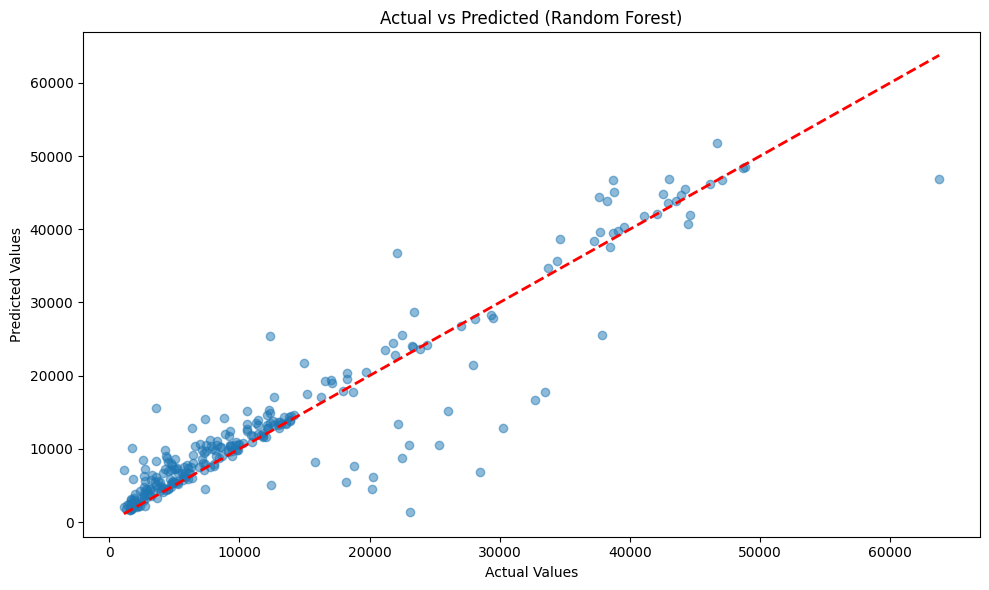

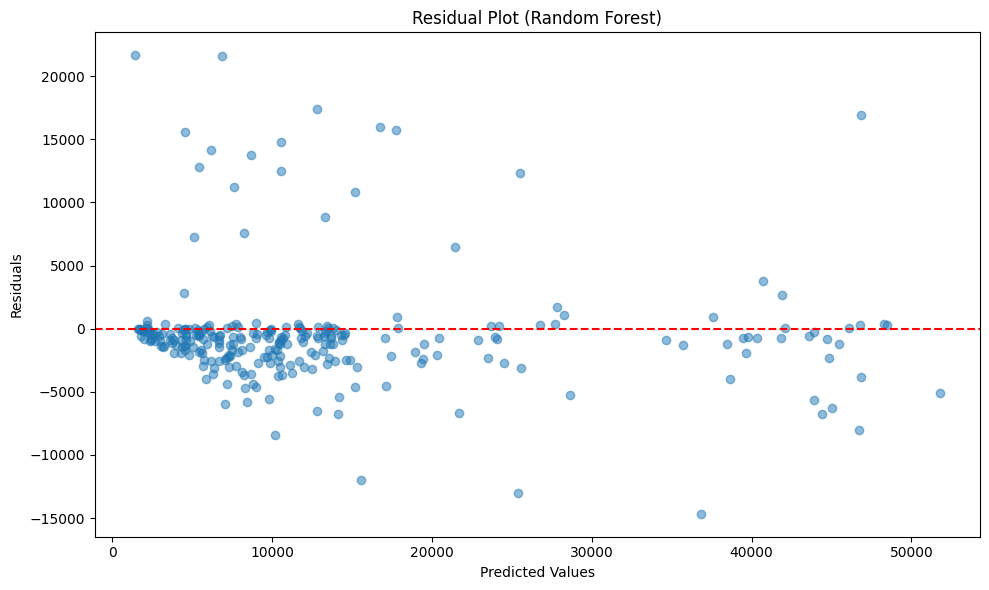


Mô hình Random Forest đã được lưu vào file 'random_forest_insurance_model.joblib'


In [35]:
# Kiểm tra phiên bản scikit-learn
if sklearn.__version__ >= '0.24':
    onehot_params = {'drop': 'first', 'sparse_output': False}
else:
    onehot_params = {'drop': 'first', 'sparse': False}

X = df.drop('charges', axis=1)
y = df['charges']

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Xây dựng pipeline
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(**onehot_params), categorical_features)
    ])

# Mô hình Random Forest
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Huấn luyện mô hình
rf_model.fit(X_train, y_train)

# Dự đoán và đánh giá
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Kết quả Random Forest:")
print(f'MSE: {mse_rf}')
print(f'RMSE: {np.sqrt(mse_rf)}')
print(f'R-squared: {r2_rf}')
print(f'MAE: {mae_rf}')

# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_rmse_rf = np.sqrt(-cv_scores_rf)
print("\nCross-validation RMSE (Random Forest):")
print(f"Mean: {cv_rmse_rf.mean()}, Std: {cv_rmse_rf.std()}")

# Feature Importance
feature_importance = rf_model.named_steps['regressor'].feature_importances_
feature_names = numeric_features + [f"{feature}_{category}" for feature, categories in 
                                    zip(categorical_features, rf_model.named_steps['preprocessor']
                                        .named_transformers_['cat'].categories_) 
                                    for category in categories[1:]]

importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

# So sánh với Linear Regression
# Tải mô hình Linear Regression đã lưu trước đó
lr_model = joblib.load('insurance_model.joblib')

y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print("\nSo sánh kết quả:")
print(f"{'Metric':<15}{'Random Forest':<20}{'Linear Regression':<20}")
print(f"{'MSE':<15}{mse_rf:<20.2f}{mse_lr:<20.2f}")
print(f"{'RMSE':<15}{np.sqrt(mse_rf):<20.2f}{np.sqrt(mse_lr):<20.2f}")
print(f"{'R-squared':<15}{r2_rf:<20.2f}{r2_lr:<20.2f}")
print(f"{'MAE':<15}{mae_rf:<20.2f}{mae_lr:<20.2f}")

# Visualize predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Random Forest)')
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_test - y_pred_rf
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (Random Forest)')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Lưu mô hình Random Forest
joblib.dump(rf_model, 'random_forest_insurance_model.joblib')
print("\nMô hình Random Forest đã được lưu vào file 'random_forest_insurance_model.joblib'")
